In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from clim_utils import label_latlons

In [2]:
file_nino='/scratch/kpegion/nino34_1982-2019.oisstv2_anoms.nc'
ds_nino=xr.open_dataset(file_nino)
ds_nino

<xarray.Dataset>
Dimensions:  (time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

In [3]:
ds_nino=ds_nino.sel(time=slice('1982-01-01','2018-12-01'))
ds_nino

<xarray.Dataset>
Dimensions:  (time: 444)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 0.17045784 -0.04168701 ... 0.8991585 0.88646126

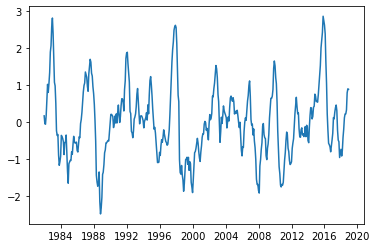

In [4]:
plt.plot(ds_nino['time'],ds_nino['sst'])

In [5]:
file='/homes/jcampb8/data-shell/thesis/enso4_1979-2018.cmap.monthly.precip.mon.mean.nc'
ds_precip=xr.open_dataset(file)
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 480)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    version:        V1912
    history:        update 12/2019 V1912
    data_modified:  2019-12-12

In [6]:
# Slice time to match Nino data
ds_precip=ds_precip.sel(time=slice(ds_nino['time'][0],ds_nino['time'][-1]))

# Make anomalies
ds_climo=ds_precip.groupby('time.month').mean()
ds_anoms=ds_precip.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 444)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 -0.119510144 -0.16511825 ... 0.4263096

Text(0, 0.5, 'Index/Anom Values')

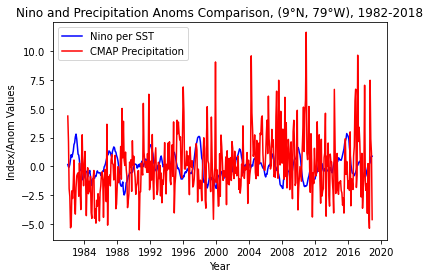

In [7]:
pt=ds_anoms.sel(lat=9,lon=360-79,method='nearest')
plt.plot(ds_nino['time'],ds_nino['sst'],'b')
plt.plot(pt['time'],pt['precip'],'r')
plt.legend(['Nino per SST','CMAP Precipitation'])
plt.title('Nino and Precipitation Anoms Comparison, (9°N, 79°W), 1982-2018')
plt.xlabel('Year')
plt.ylabel('Index/Anom Values')

In [8]:
R=np.corrcoef(ds_nino['sst'],pt['precip'])
R

array([[ 1.        , -0.16867457],
       [-0.16867457,  1.        ]])

In [9]:
corr=R[0,1]
corr

-0.1686745696253809

In [10]:
r_map=xr.corr(ds_nino['sst'],ds_anoms['precip'],dim='time')
r_map

<xarray.DataArray (lat: 32, lon: 36)>
array([[-0.04289125, -0.00150374,  0.03706669, ..., -0.09243194,
         0.02702695,  0.08065953],
       [ 0.00574591,  0.08347373,  0.08489507, ..., -0.04321816,
         0.04252121,  0.00402158],
       [ 0.04407483,  0.12481786,  0.09656904, ..., -0.00652004,
         0.04965089,  0.01984758],
       ...,
       [ 0.4577594 ,  0.41157854,  0.39992753, ..., -0.19669354,
        -0.19259839, -0.25140125],
       [ 0.39094306,  0.34527814,  0.31882505, ..., -0.18426659,
        -0.19308574, -0.23918344],
       [ 0.38408229,  0.3398194 ,  0.31734569, ..., -0.16098984,
        -0.10000044, -0.18154663]])
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75

Text(0.5, 1.0, 'Correlation between Nino3.4 and Precipitation Anomalies')

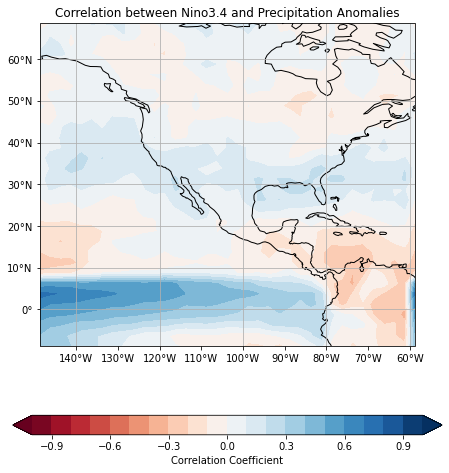

In [11]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(220,310,10),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(0,70,10),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)


# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')

In [12]:
from scipy.stats import pearsonr

In [13]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_nino['sst'],ds_anoms['precip'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p
r_array.shape

(32, 36)

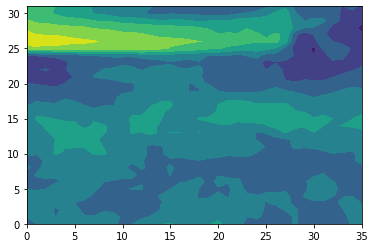

In [14]:
plt.contourf(r_array)

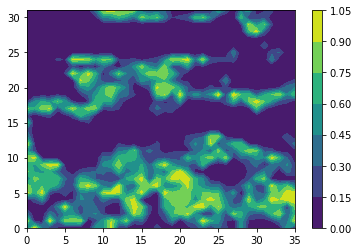

In [15]:
plt.contourf(p_array)
plt.colorbar()

In [16]:
mask_sig=np.where(p_array<0.05,r_array,np.nan)

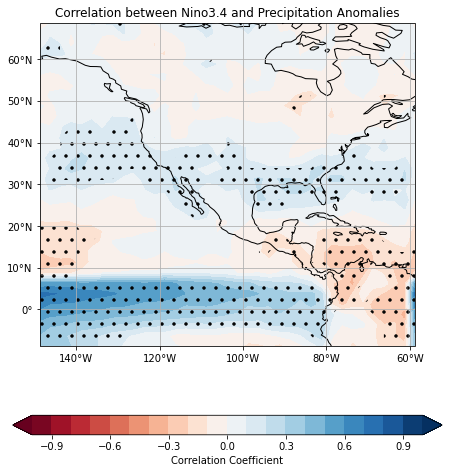

In [17]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(220,310,20),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(0,70,10),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')
plt.savefig('Correlaton-ENSO,Precip')